In [0]:
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path = "/content/drive/My Drive/"
print(path)

/content/drive/My Drive/


In [4]:
my_df = pd.read_csv(f'{path}/loan.csv', low_memory= False)
print(my_df.shape)
my_df.head(3)

(2260668, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,Apr-2011,0.0,NaN,NaN,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Print out list of columns
my_df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

##### Now, let's check if there are any null/NaN values in our data, if so, what is the percentage for each column?

In [0]:
missing_percent = my_df.isnull().sum()*100 / len(my_df)

In [7]:
missing_percent

id                       100.000000
member_id                100.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
                            ...    
settlement_status         98.537777
settlement_date           98.537777
settlement_amount         98.537777
settlement_percentage     98.537777
settlement_term           98.537777
Length: 145, dtype: float64

##### From above results, we can see there are many columns with lot of null/NaN data. Let's find out columns where more than 50% of the data is missing and then drop those columns

In [0]:
missing_fractions = my_df.isnull().mean()

In [9]:
missing_fractions

id                       1.000000
member_id                1.000000
loan_amnt                0.000000
funded_amnt              0.000000
funded_amnt_inv          0.000000
                           ...   
settlement_status        0.985378
settlement_date          0.985378
settlement_amount        0.985378
settlement_percentage    0.985378
settlement_term          0.985378
Length: 145, dtype: float64

Text(0, 0.5, 'Number of columns')

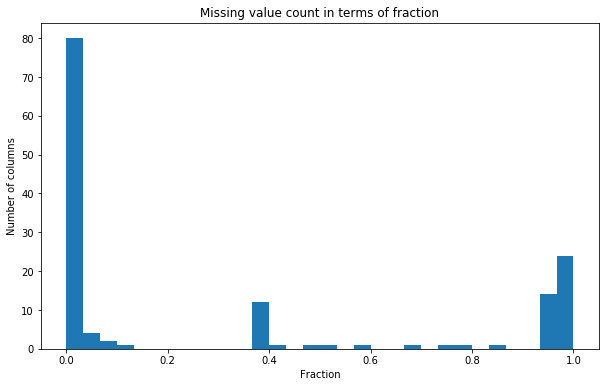

In [10]:
# Visualize the missing fraction in a graph
plt.figure(figsize=(10,6))
missing_fractions.plot.hist(bins=30)
plt.title('Missing value count in terms of fraction')
plt.xlabel('Fraction')
plt.ylabel('Number of columns')

##### From above graph we can see that 
     1. There are a few columns having 35% or more missing data and 
     2. A few columns have 50 to 85% missing data
     3. Nearly 30 columns have 90 to 100% missing data
  Drop columns with missing data > 35%

In [0]:
drop_colList = list(missing_fractions[missing_fractions > 0.35].index)

In [12]:
drop_colList

['id',
 'member_id',
 'url',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dp

In [13]:
len(drop_colList)

58

In [0]:
my_df.drop(drop_colList, axis=1, inplace=True)

In [15]:
my_df.shape

(2260668, 87)

##### Now, our motive is to find out whether a person will be able to pay back the loan to the bank or not. Let's see what values are there in loan_status!

In [16]:
my_df.loan_status.unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

##### We will only be predicting whether loan_status was fully paid by the loaner or was it charged off (i.e. the person coouldn't pay for the loan and bank stopped giving money to the person)
##### And so, we will drop the rows having data other than 'Fully Paid' or 'Charged Off'.

In [0]:
my_df = my_df.loc[my_df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [18]:
my_df.shape

(1303607, 87)

In [0]:
# Convert loan_status to 0's(Fully Paid) and 1's(Charged Off)
loan_status_converted = {"Fully Paid":0, "Charged Off":1}
my_df = my_df.replace({"loan_status" : loan_status_converted})

In [20]:
my_df.loan_status.unique()

array([0, 1])

In [21]:
my_df.shape

(1303607, 87)

In [22]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303607 entries, 100 to 2260664
Data columns (total 87 columns):
loan_amnt                     1303607 non-null int64
funded_amnt                   1303607 non-null int64
funded_amnt_inv               1303607 non-null float64
term                          1303607 non-null object
int_rate                      1303607 non-null float64
installment                   1303607 non-null float64
grade                         1303607 non-null object
sub_grade                     1303607 non-null object
emp_title                     1221028 non-null object
emp_length                    1228153 non-null object
home_ownership                1303607 non-null object
annual_inc                    1303607 non-null float64
verification_status           1303607 non-null object
issue_d                       1303607 non-null object
loan_status                   1303607 non-null int64
pymnt_plan                    1303607 non-null object
purpose             

##### After careful research through data dictionary, we are going to keep below columns to predict the output (loan_status)

In [23]:
feature_list = ['annual_inc', 'grade', 'emp_length', 'funded_amnt', 
                'avg_cur_bal', 'last_pymnt_amnt', 'open_acc', 'bc_util', 'mort_acc', 'pub_rec', 
                'debt_settlement_flag', 'term', 'installment', 'int_rate', 'delinq_2yrs', 'home_ownership', 
                'acc_now_delinq', 'loan_amnt', 'total_pymnt', 'loan_status']
my_df_final = my_df[feature_list]
my_df_final = my_df_final.reset_index(drop=True)
my_df_final.shape

(1303607, 20)

In [24]:
my_df_final.head()

,annual_inc,grade,emp_length,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt,loan_status
0,100000.0,D,5 years,30000,42939.0,30082.32,11.0,46.9,1.0,1.0,N,36 months,1151.16,22.35,0.0,MORTGAGE,0.0,30000,30026.442500,0
1,45000.0,C,< 1 year,40000,15059.0,40910.48,18.0,67.3,1.0,0.0,N,60 months,975.71,16.14,0.0,MORTGAGE,0.0,40000,40856.678960,0
2,100000.0,A,10+ years,20000,57309.0,20228.39,9.0,29.9,5.0,0.0,N,36 months,622.68,7.56,0.0,MORTGAGE,0.0,20000,20215.792430,0
3,38500.0,B,10+ years,4500,2428.0,4553.46,12.0,28.9,0.0,0.0,N,36 months,147.99,11.31,0.0,RENT,0.0,4500,4549.217149,0
4,450000.0,E,3 years,8425,34516.0,8754.30,21.0,74.6,4.0,0.0,N,36 months,345.18,27.27,0.0,MORTGAGE,0.0,8425,8735.148975,0


In [25]:
my_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303607 entries, 0 to 1303606
Data columns (total 20 columns):
annual_inc              1303607 non-null float64
grade                   1303607 non-null object
emp_length              1228153 non-null object
funded_amnt             1303607 non-null int64
avg_cur_bal             1236059 non-null float64
last_pymnt_amnt         1303607 non-null float64
open_acc                1303607 non-null float64
bc_util                 1242221 non-null float64
mort_acc                1256326 non-null float64
pub_rec                 1303607 non-null float64
debt_settlement_flag    1303607 non-null object
term                    1303607 non-null object
installment             1303607 non-null float64
int_rate                1303607 non-null float64
delinq_2yrs             1303607 non-null float64
home_ownership          1303607 non-null object
acc_now_delinq          1303607 non-null float64
loan_amnt               1303607 non-null int64
total_pymnt   

##### Now, change the categorial data to numerical by following below steps:

In [26]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

my_df_final["grade"] = lb_make.fit_transform(my_df_final["grade"])
my_df_final["emp_length"] = my_df_final["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, 
                                                              regex = True)
my_df_final.astype({'emp_length':'float'})
my_df_final["debt_settlement_flag"] = lb_make.fit_transform(my_df_final["debt_settlement_flag"])
my_df_final["home_ownership"] = lb_make.fit_transform(my_df_final["home_ownership"])
my_df_final["term"] = lb_make.fit_transform(my_df_final["term"])

print("Current shape of dataset :", my_df_final.shape)
my_df_final.head()

Current shape of dataset : (1303607, 20)


,annual_inc,grade,emp_length,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt,loan_status
0,100000.0,3,5,30000,42939.0,30082.32,11.0,46.9,1.0,1.0,0,0,1151.16,22.35,0.0,1,0.0,30000,30026.442500,0
1,45000.0,2,1,40000,15059.0,40910.48,18.0,67.3,1.0,0.0,0,1,975.71,16.14,0.0,1,0.0,40000,40856.678960,0
2,100000.0,0,10,20000,57309.0,20228.39,9.0,29.9,5.0,0.0,0,0,622.68,7.56,0.0,1,0.0,20000,20215.792430,0
3,38500.0,1,10,4500,2428.0,4553.46,12.0,28.9,0.0,0.0,0,0,147.99,11.31,0.0,5,0.0,4500,4549.217149,0
4,450000.0,4,3,8425,34516.0,8754.30,21.0,74.6,4.0,0.0,0,0,345.18,27.27,0.0,1,0.0,8425,8735.148975,0


In [27]:
#Check how many null values do we have in our final dataset
my_df_final.isnull().sum()

annual_inc                  0
grade                       0
emp_length              75454
funded_amnt                 0
avg_cur_bal             67548
last_pymnt_amnt             0
open_acc                    0
bc_util                 61386
mort_acc                47281
pub_rec                     0
debt_settlement_flag        0
term                        0
installment                 0
int_rate                    0
delinq_2yrs                 0
home_ownership              0
acc_now_delinq              0
loan_amnt                   0
total_pymnt                 0
loan_status                 0
dtype: int64

In [0]:
#Impute the NaN data by calculating mean of that particular feature
my_df_final.fillna(my_df_final.mean(), inplace=True)

In [29]:
#Check if we still have any missing values (not NaN's)
my_df_final.isnull().sum()

annual_inc                  0
grade                       0
emp_length              75454
funded_amnt                 0
avg_cur_bal                 0
last_pymnt_amnt             0
open_acc                    0
bc_util                     0
mort_acc                    0
pub_rec                     0
debt_settlement_flag        0
term                        0
installment                 0
int_rate                    0
delinq_2yrs                 0
home_ownership              0
acc_now_delinq              0
loan_amnt                   0
total_pymnt                 0
loan_status                 0
dtype: int64

In [0]:
# Drop 'emp_length'column
my_df_final.drop('emp_length', axis=1, inplace=True)

In [32]:
my_df_final.head()

,annual_inc,grade,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt,loan_status
0,100000.0,3,30000,42939.0,30082.32,11.0,46.9,1.0,1.0,0,0,1151.16,22.35,0.0,1,0.0,30000,30026.442500,0
1,45000.0,2,40000,15059.0,40910.48,18.0,67.3,1.0,0.0,0,1,975.71,16.14,0.0,1,0.0,40000,40856.678960,0
2,100000.0,0,20000,57309.0,20228.39,9.0,29.9,5.0,0.0,0,0,622.68,7.56,0.0,1,0.0,20000,20215.792430,0
3,38500.0,1,4500,2428.0,4553.46,12.0,28.9,0.0,0.0,0,0,147.99,11.31,0.0,5,0.0,4500,4549.217149,0
4,450000.0,4,8425,34516.0,8754.30,21.0,74.6,4.0,0.0,0,0,345.18,27.27,0.0,1,0.0,8425,8735.148975,0


In [38]:
print(my_df_final.shape)

(1303607, 19)


In [44]:
my_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303607 entries, 0 to 1303606
Data columns (total 19 columns):
annual_inc              1303607 non-null float64
grade                   1303607 non-null int64
funded_amnt             1303607 non-null int64
avg_cur_bal             1303607 non-null float64
last_pymnt_amnt         1303607 non-null float64
open_acc                1303607 non-null float64
bc_util                 1303607 non-null float64
mort_acc                1303607 non-null float64
pub_rec                 1303607 non-null float64
debt_settlement_flag    1303607 non-null int64
term                    1303607 non-null int64
installment             1303607 non-null float64
int_rate                1303607 non-null float64
delinq_2yrs             1303607 non-null float64
home_ownership          1303607 non-null int64
acc_now_delinq          1303607 non-null float64
loan_amnt               1303607 non-null int64
total_pymnt             1303607 non-null float64
loan_status      

**Now do the scaling**

In [45]:
cols = my_df_final.columns.values[:-1]

scaler = preprocessing.StandardScaler()
my_df_scaled = pd.DataFrame(scaler.fit_transform(my_df_final[cols]), columns=cols)
my_df_scaled['loan_status'] = my_df_final['loan_status']
print(my_df_scaled.head())

   annual_inc     grade  funded_amnt  ...  loan_amnt  total_pymnt  loan_status
0    0.340348  0.962661     1.793104  ...   1.791267     1.475098            0
1   -0.444818  0.191616     2.943128  ...   2.940753     2.523710            0
2    0.340348 -1.350475     0.643080  ...   0.641781     0.525205            0
3   -0.537610 -0.579430    -1.139458  ...  -1.139923    -0.991674            0
4    5.336860  1.733707    -0.688073  ...  -0.688750    -0.586381            0

[5 rows x 19 columns]


In [46]:
my_df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303607 entries, 0 to 1303606
Data columns (total 19 columns):
annual_inc              1303607 non-null float64
grade                   1303607 non-null float64
funded_amnt             1303607 non-null float64
avg_cur_bal             1303607 non-null float64
last_pymnt_amnt         1303607 non-null float64
open_acc                1303607 non-null float64
bc_util                 1303607 non-null float64
mort_acc                1303607 non-null float64
pub_rec                 1303607 non-null float64
debt_settlement_flag    1303607 non-null float64
term                    1303607 non-null float64
installment             1303607 non-null float64
int_rate                1303607 non-null float64
delinq_2yrs             1303607 non-null float64
home_ownership          1303607 non-null float64
acc_now_delinq          1303607 non-null float64
loan_amnt               1303607 non-null float64
total_pymnt             1303607 non-null float64
loan_

In [0]:
x = my_df_scaled.drop('loan_status', axis=1)
y = my_df_scaled['loan_status']

In [51]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, random_state=1)
print(x_trn.shape,x_val.shape,y_trn.shape,y_val.shape)

(977705, 18) (325902, 18) (977705,) (325902,)


# Random Forest: model training, tuning, and evaluation

In [54]:
mod_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)
mod_1.fit(x_trn,y_trn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

**Apply this on Test data now!**

In [55]:
y_prd = mod_1.predict(x_val)
accuracy_score(y_val,y_prd)

0.9932648464875944